In [1]:
import numpy as np
import pandas as pd
import itertools
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

In [26]:
dsc_output = "/gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/blockdiag"

dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
respkl   = os.path.join("../dsc/results", dsc_fname + ".pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")

if os.path.isfile(dscoutpkl):
    dscout = pd.read_pickle(dscoutpkl)
else:
    print ("Could not find dscout from dscquery")

refresh_pickle = True
target = ["blockdiag"] + [f"blockdiag.{prop}" for prop in ["n", "p", "k", "h2", "h2_shared_frac", "aq", "a0"]]

condition = [""]

print ("Reading from DSC database:")
print (f"    {db}")
print ("")

qp = dscQP(db, target, condition)
df = qp.output_table

df

Could not find dscout from dscquery
Reading from DSC database:
    /gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/blockdiag/blockdiag.db



,DSC,blockdiag.output.file,blockdiag.n,blockdiag.p,blockdiag.k,blockdiag.h2,blockdiag.h2_shared_frac,blockdiag.aq,blockdiag.a0
0,1,blockdiag/blockdiag_1,500,1000,100,0.6,0.6,0.6,0.2


In [27]:
fprefix = df.loc[df['DSC'] == 1]['blockdiag.output.file'].values[0]
fname = os.path.join(dsc_output, f"{fprefix}.pkl")
data  = dsc_io.load_dsc(fname)

In [63]:
Z = data['Z']
Z_cent = Z - np.mean(Z, axis = 0, keepdims = True)
labels = np.array(data['Ctrue'])

In [64]:
import scipy.stats as sc_stats
import sys
sys.path.append("/gpfs/commons/home/sbanerjee/work/npd/npd-notes/notebooks/utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

def q1(x, axis = None):
    return np.percentile(x, 25, axis = axis)

def q3(x, axis = None):
    return np.percentile(x, 75, axis = axis)

def iqr_outlier(x, axis = None, bar = 1.5, side = 'both'):
    assert side in ['gt', 'lt', 'both'], 'Side should be `gt`, `lt` or `both`.'

    d_iqr = sc_stats.iqr(x, axis = axis)
    d_q1 = q1(x, axis = axis)
    d_q3 = q3(x, axis = axis)
    iqr_distance = np.multiply(d_iqr, bar)

    stat_shape = list(x.shape)

    if isinstance(axis, collections.abc.Iterable):
        for single_axis in axis:
            stat_shape[single_axis] = 1
    else:
        stat_shape[axis] = 1

    if side in ['gt', 'both']:
        upper_range = d_q3 + iqr_distance
        upper_outlier = np.greater(x - upper_range.reshape(stat_shape), 0)
    if side in ['lt', 'both']:
        lower_range = d_q1 - iqr_distance
        lower_outlier = np.less(x - lower_range.reshape(stat_shape), 0)

    if side == 'gt':
        return upper_outlier
    if side == 'lt':
        return lower_outlier
    if side == 'both':
        return np.logical_or(upper_outlier, lower_outlier)

def get_density(x, data):
    density = sc_stats.gaussian_kde(data)
    return density.pdf(x)

def get_bins(data, nbin, xmin, xmax):
    xdelta = (np.max(data) - np.min(data)) / 10
    if not xmin: xmin = np.min(data) - xdelta
    if not xmax: xmax = np.max(data) + xdelta
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    return xmin, xmax, bins, xbin

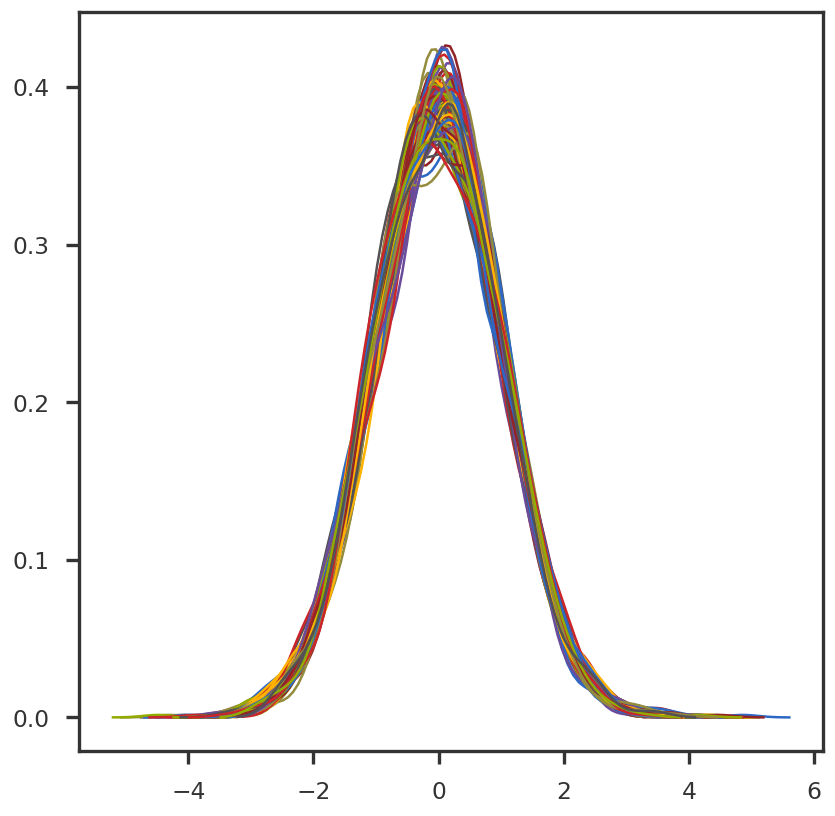

In [65]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for n in range(100):
    scores = Z[n, :]
    scores_cent = scores / np.std(scores)
    scores_cent -= np.mean(scores_cent)
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, None, None)
    curve = get_density(xbin, scores_cent)
    ax1.plot(xbin, curve)

plt.show()

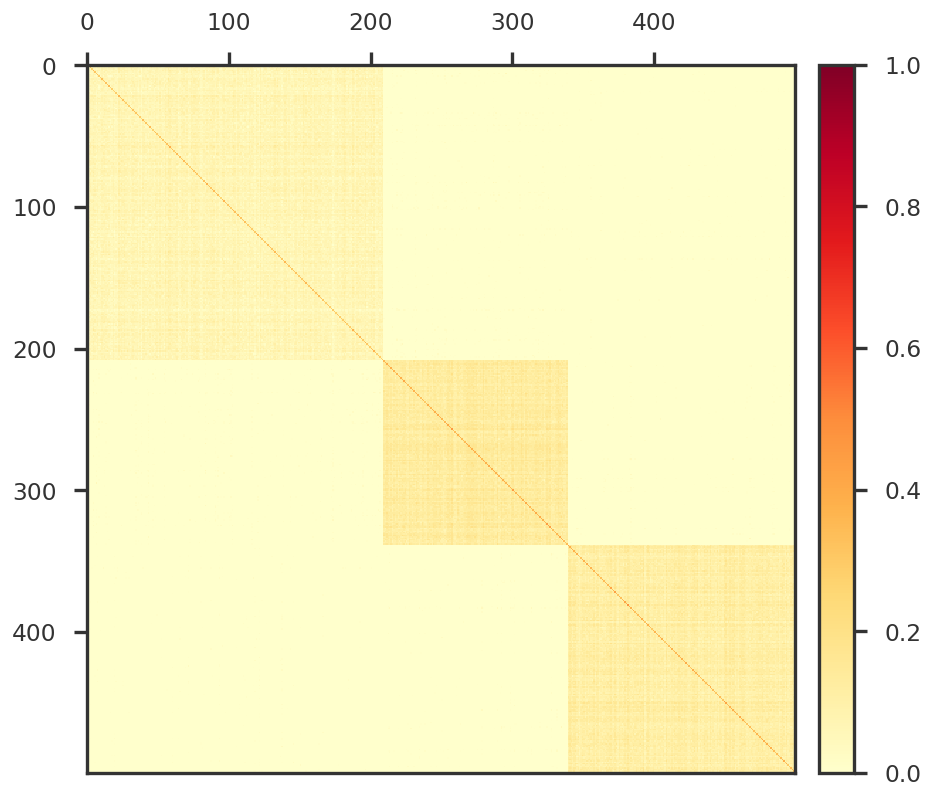

In [66]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, Z_cent * np.sqrt(1000) / np.sqrt(10000))
#mpy_plotfn.plot_covariance_heatmap(ax1, data['Ltrue'] * np.sqrt(100))

plt.tight_layout()
plt.show()

In [67]:
from nnwmf.optimize import IALM
rpca = IALM(max_iter = 1000, mu_update_method='admm', show_progress = False)
rpca.fit(Z_cent)

In [80]:
from nnwmf.utils import model_errors as merr

def _generate_fold_labels(Y, kfolds = 5, shuffle = True, test_size = None):
    n, p = Y.shape
    fold_labels = np.ones(n * p)
    if test_size is None:
        ntest = int ((n * p) / kfolds)
    else:
        ntest = int(test_size * n * p)
    for k in range(1, kfolds):
        start = k * ntest
        end = (k + 1) * ntest
        fold_labels[start: end] = k + 1
    if shuffle:
        np.random.shuffle(fold_labels)
    return fold_labels.reshape(n, p)


def _generate_masked_input(Y, mask):
    Ymiss_nan = Y.copy()
    Ymiss_nan[mask] = np.nan
    Ymiss_nan_cent = Ymiss_nan - np.nanmean(Ymiss_nan, axis = 0, keepdims = True)
    Ymiss_nan_cent[mask] = 0.0
    return Ymiss_nan_cent

def _generate_rseq(r_min = None, r_max = None, nseq = None):
    a_min = 0 if r_min is None else int(np.floor(np.log2(r_min)))
    a_max = max(0, a_min + 1) if r_max is None else int(np.floor(np.log2(r_max)) + 1)
    if nseq is None:
        nseq  = a_max - a_min + 1
    rseq = np.logspace(a_min, a_max, num = nseq, base = 2.0)
    return rseq

In [82]:
lmb_values = _generate_rseq(0.015, 0.05, nseq = 10)
kfolds = 2

test_errors =  {r: list() for r in lmb_values}
train_errors = {r: list() for r in lmb_values}
rpca_models  = {r: list() for r in lmb_values}

fold_labels = _generate_fold_labels(Z_cent, kfolds = kfolds)
for k in range(kfolds):
    print (f"Fold {k + 1}")
    mask = fold_labels == k + 1
    Ymiss = _generate_masked_input(Z_cent, mask)
    for lmb in lmb_values:
        rpca_cv = IALM(mu_update_method='admm', show_progress = False, debug = True, max_iter = 100)
        rpca_cv.fit(Ymiss, lmb = lmb, mask = mask)
        rpca_models[lmb].append(rpca_cv)
        recovered = mpy_simulate.do_standardize(rpca_cv.L_, scale = False)
        train_err_k  = merr.get(Z_cent, recovered, mask, method = 'rmse')
        test_err_k = merr.get(Z_cent, recovered, ~mask, method = 'rmse')
        train_errors[lmb].append(train_err_k)
        test_errors[lmb].append(test_err_k)

Fold 1
2024-01-14 16:08:01,032 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0078)
2024-01-14 16:08:19,266 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0098)
2024-01-14 16:08:36,512 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0124)
2024-01-14 16:09:03,303 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0156)
2024-01-14 16:09:33,317 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0197)
2024-01-14 16:10:05,829 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0248)
2024-01-14 16:10:39,354 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0312)
2024-01-14 16:11:15,856 | nnwmf.optimize.inexact_alm               | 

In [84]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics as skmetrics

def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    return pcomps

def get_adjusted_MI_score(x, class_labels):
    pcomp = get_principal_components(x)
    distance_matrix = skmetrics.pairwise.pairwise_distances(pcomp, metric='euclidean')
    model = AgglomerativeClustering(n_clusters = 4, linkage = 'average', metric = 'precomputed')
    class_pred = model.fit_predict(distance_matrix)
    return skmetrics.adjusted_mutual_info_score(class_labels, class_pred)

adj_mi_scores = {r: list() for r in lmb_values}
recovered_matrix_ranks = {r: list() for r in lmb_values}
for k in range(kfolds):
    for lmb in lmb_values:
        mask = fold_labels == k + 1
        adj_mi_scores[lmb].append(get_adjusted_MI_score(rpca_models[lmb][k].L_, labels))
        recovered_matrix_ranks[lmb].append(np.linalg.matrix_rank(rpca_models[lmb][k].L_))

In [86]:
train_errors

{0.0078125: [1.841681892749783, 1.8480632232702858],
 0.009843133202303695: [1.841681892749783, 1.8480632232702858],
 0.012401570718501561: [1.841681892749783, 1.8480632232702858],
 0.015625: [1.841681892749783, 1.8480632232702858],
 0.01968626640460739: [1.841681892749783, 1.8480632232702858],
 0.024803141437003108: [1.8416818925383172, 1.8480632231921204],
 0.03125: [1.841681899660682, 1.8480632309095275],
 0.03937253280921478: [1.8416382147051746, 1.8480392651290842],
 0.049606282874006216: [1.8416278715746437, 1.8480237122007197],
 0.0625: [1.8416311882560779, 1.8480308231181448]}

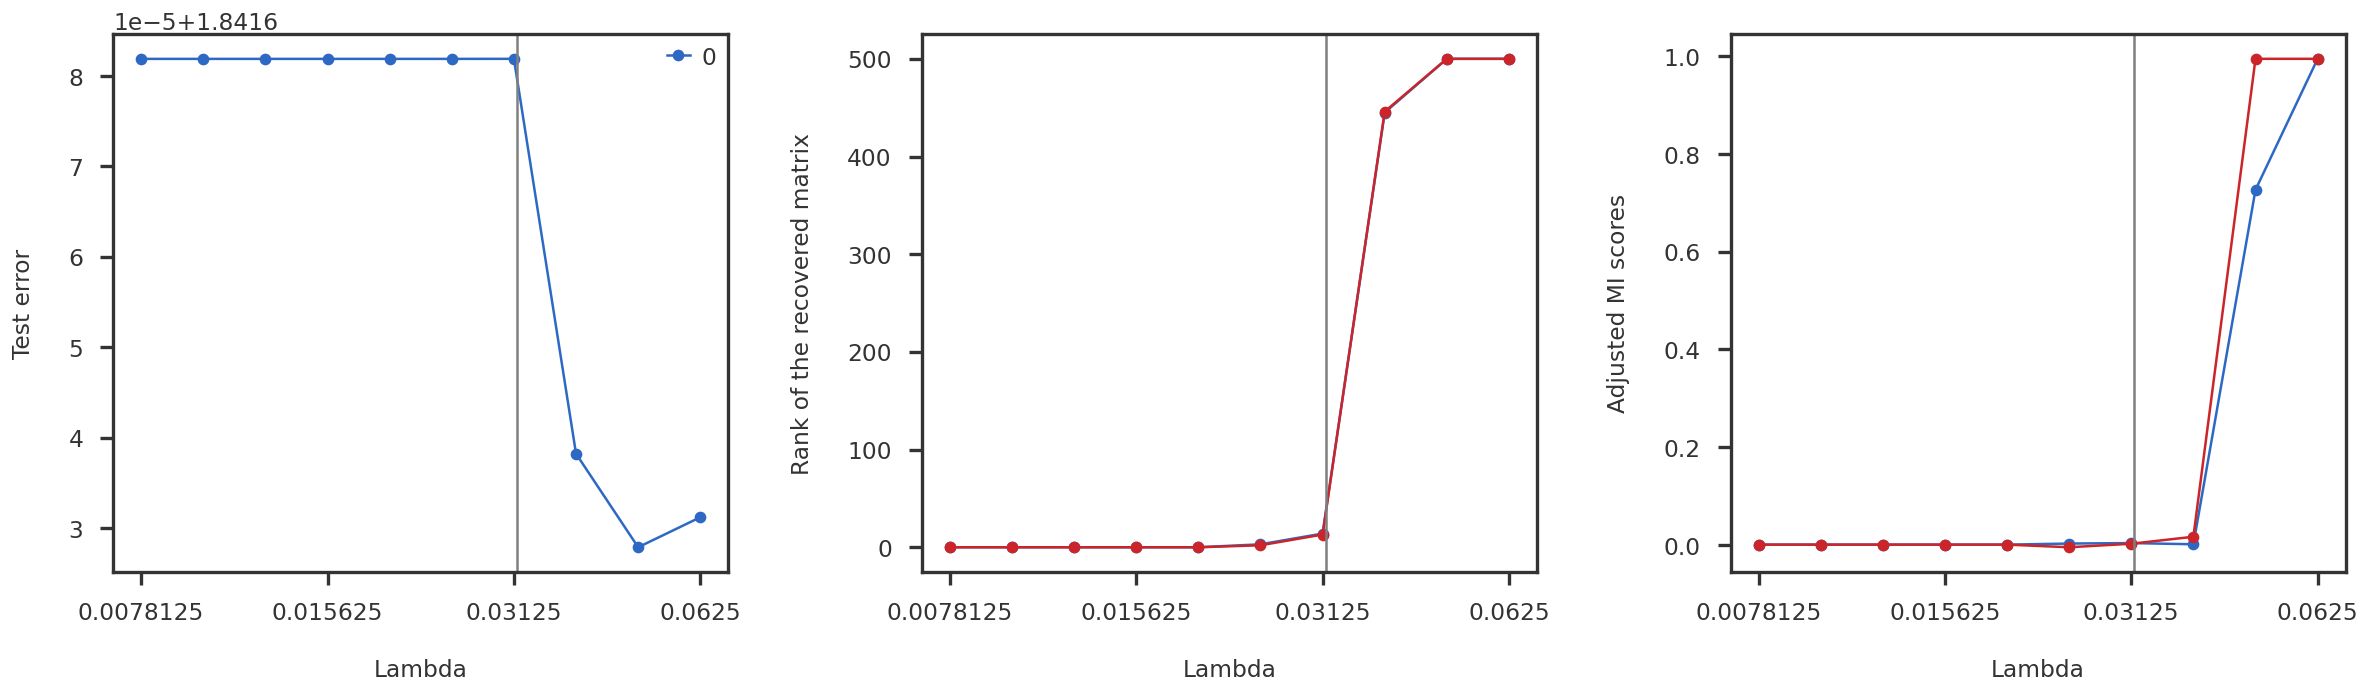

In [96]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(131)
for k in range(1):
    ax1.plot(np.log2(lmb_values), [x[k] for x in train_errors.values()], 'o-', label = k)
ax1.axvline(x = np.log2(1. / np.sqrt(np.max(Z.shape))), color = 'grey')
ax1.legend()
ax1.set_ylabel("Test error")
ax1.set_xlabel("Lambda")

ax2 = fig.add_subplot(132)
for k in range(kfolds):
    ax2.plot(np.log2(lmb_values), [x[k] for x in recovered_matrix_ranks.values()], 'o-')
ax2.axvline(x = np.log2(1. / np.sqrt(np.max(Z.shape))), color = 'grey')
ax2.set_ylabel("Rank of the recovered matrix")
ax2.set_xlabel("Lambda")

ax3 = fig.add_subplot(133)
for k in range(kfolds):
    ax3.plot(np.log2(lmb_values), [x[k] for x in adj_mi_scores.values()], 'o-')
ax3.axvline(x = np.log2(1. / np.sqrt(np.max(Z.shape))), color = 'grey')
ax3.set_ylabel("Adjusted MI scores")
ax3.set_xlabel("Lambda")

for ax in [ax1, ax2, ax3]:
    mpl_utils.set_xticks(ax, scale = 'log2', spacing = 'log2')

plt.tight_layout(w_pad = 2.0)
plt.show()

In [110]:
from scipy.spatial import procrustes

def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps

loadings_rpca, pcomps_rpca = get_principal_components(rpca.L_)
Ltrue_std, Lfit, err_rpca = procrustes(pcomps_rpca[:, :100], data['Ltrue'])

In [111]:
err_rpca

0.07287925835079676

In [112]:
pcomps_rpca.shape

(500, 500)

In [113]:
data['Ltrue'].shape

(500, 100)

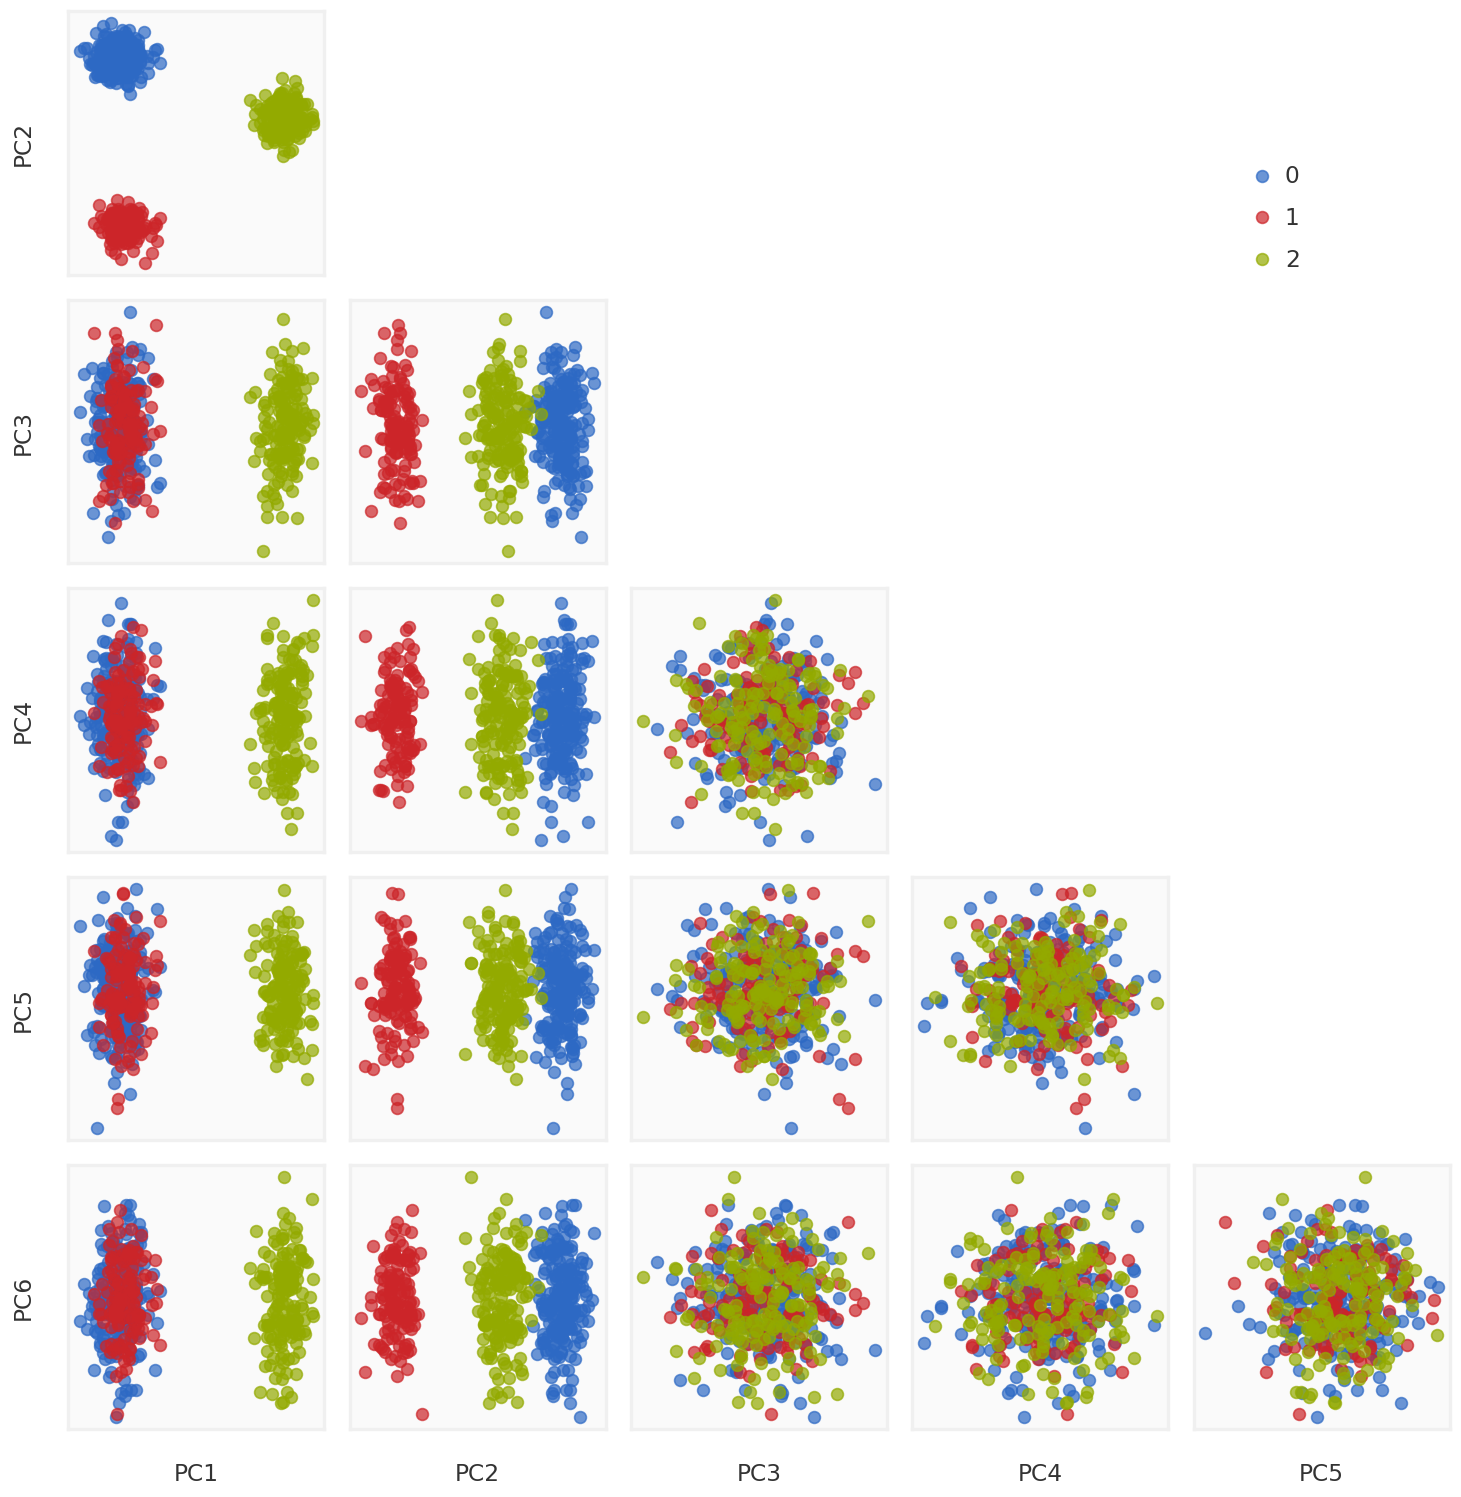

In [114]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca[:, :100], labels, list(set(labels)))
plt.show()